In [51]:
from DataLoader import load_data

subject_name = 'subject_023'
src_dir = 'Desktop/eeg-data/Subjects-Data/'
##EEG Inception Model Definition. 
Train_data, Train_data_inception, Train_data_flattened, Train_labels = load_data(src_dir, subject_name)


['PF32_2016_12_05_train32FFS001R01.dat', 'PF32_2016_12_05_train32FFS001R02.dat', 'PF32_2016_12_05_train32FFS001R03.dat', 'pf_training.prm']


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 32, 192)
(3600,)
(3600, 4096)


In [52]:
#EEGNet Training

# EEGNet-specific imports
from EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

# PyRiemann imports
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.viz import plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


# tools for plotting confusion matrices
from matplotlib import pyplot as plt

# while the default tensorflow ordering is 'channels_last' we set it here
# to be explicit in case if the user has changed the default ordering
K.set_image_data_format('channels_last')

# extract raw data. scale by 1000 due to scaling sensitivity in deep learning
X = Train_data # format is in (trials, channels, samples)
y = Train_labels
kernels, chans, samples = 1, 32, 192


# take 60/20/20 percent of the data to train/validate/test
End_index = len(Train_labels)
#End_index = len(Ys_train)
Train_index = (int) (End_index * 0.6)
Val_index = (int) (End_index * 0.8)

X_train      = X[0:Train_index,]
Y_train      = y[0:Train_index]
X_validate   = X[Train_index:Val_index,]
Y_validate   = y[Train_index:Val_index]
X_test       = X[Val_index:,]
Y_test       = y[Val_index:]


# Split daa for RG+xDrawn training done in later steps
RG_train_data      = X[0:Val_index,]
RG_train_labels      = y[0:Val_index]
RG_test_data       = X[Val_index:,]
RG_test_labels       = y[Val_index:] 



#print(Y_train)
############################# EEGNet portion ##################################

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(Y_train,  num_classes=2)
Y_validate   = np_utils.to_categorical(Y_validate,  num_classes=2)
Y_test       = np_utils.to_categorical(Y_test,  num_classes=2)
RG_train_labels      = np_utils.to_categorical(RG_train_labels,  num_classes=2)
RG_test_labels       = np_utils.to_categorical(RG_test_labels,  num_classes=2)

# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
print(np.shape(X_train))   

# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
# model configurations may do better, but this is a good starting point)
model = EEGNet(nb_classes = 2, Chans = chans, Samples = samples, 
               dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')

# compile the model and set the optimizers
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()    

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

###############################################################################
# if the classification task was imbalanced (significantly more trials in one
# class versus the others) you can assign a weight to each class during 
# optimization to balance it out. This data is approximately balanced so we 
# don't need to do this, but is shown here for illustration/completeness. 
###############################################################################

# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
class_weights = {0:5, 1:1}

################################################################################
# fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
# Riemannian geometry classification (below)
################################################################################
fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 300, 
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer], class_weight = class_weights)

# load optimal weights
model.load_weights('/tmp/checkpoint.h5')


(2160, 32, 192, 1)
Train on 2160 samples, validate on 720 samples
Epoch 1/300

Epoch 00001: val_loss improved from inf to 1.77157, saving model to /tmp/checkpoint.h5
2160/2160 - 7s - loss: 1.7052 - accuracy: 0.8074 - val_loss: 1.7716 - val_accuracy: 0.8333
Epoch 2/300

Epoch 00002: val_loss improved from 1.77157 to 1.17145, saving model to /tmp/checkpoint.h5
2160/2160 - 5s - loss: 0.9741 - accuracy: 0.8333 - val_loss: 1.1714 - val_accuracy: 0.8333
Epoch 3/300

Epoch 00003: val_loss improved from 1.17145 to 0.93108, saving model to /tmp/checkpoint.h5
2160/2160 - 6s - loss: 0.8124 - accuracy: 0.8333 - val_loss: 0.9311 - val_accuracy: 0.8333
Epoch 4/300

Epoch 00004: val_loss improved from 0.93108 to 0.81835, saving model to /tmp/checkpoint.h5
2160/2160 - 5s - loss: 0.7528 - accuracy: 0.8333 - val_loss: 0.8183 - val_accuracy: 0.8333
Epoch 5/300

Epoch 00005: val_loss improved from 0.81835 to 0.76962, saving model to /tmp/checkpoint.h5
2160/2160 - 5s - loss: 0.7303 - accuracy: 0.8333 - val

In [53]:
#EEG Inception Training


#%% IMPORT LIBRARIES
from EEG-Inception import EEGInception
import numpy as np
import h5py, os
#from EEGInception import EEGInception
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder

#%% PARAMETERS

#dataset_path = 'Desktop/GIB-UVA ERP-BCI.hdf5'

#%% HYPERPARAMETERS

input_time = 1000
fs = 192
n_cha = 32
filters_per_branch = 8
scales_time = (500, 250, 125)
dropout_rate = 0.25
activation = 'elu'
n_classes = 2
learning_rate = 0.001

#features, features_test, erp_labels, labels_test = train_test_split(Train_data_inception, Train_labels, test_size=0.20, random_state=42)

End_index = len(Train_labels)
Train_index = (int) (End_index * 0.8)

features=Train_data_inception[0:Train_index,]
erp_labels = Train_labels[0:Train_index,]
features_test = Train_data_inception[Train_index:,]
labels_test = Train_labels[Train_index:]
                          

#%% PREPARE FEATURES AND LABELS
# Reshape epochs for EEG-Inception
features_test = features_test.reshape(
    (features_test.shape[0], features_test.shape[1],
     features_test.shape[2], 1)
)
features = features.reshape(
    (features.shape[0], features.shape[1],
     features.shape[2], 1)
)

# One hot encoding of labels
def one_hot_labels(caategorical_labels):
    enc = OneHotEncoder(handle_unknown='ignore')
    on_hot_labels = enc.fit_transform(
        caategorical_labels.reshape(-1, 1)).toarray()
    return on_hot_labels


train_erp_labels = one_hot_labels(erp_labels)
labels_test = one_hot_labels(labels_test)    

# Create model
inception_model = EEGInception(
   input_time=1000, fs=192, ncha=32, filters_per_branch=8,
   scales_time=(500, 250, 125), dropout_rate=0.25,
   activation='elu', n_classes=2, learning_rate=0.001)


# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', min_delta=0.0001,
    mode='min', patience=10, verbose=1,
    restore_best_weights=True)

# Fit model
fit_hist = inception_model.fit(features,
                     train_erp_labels,
                     epochs=500,
                     batch_size=16,
                     validation_split=0.2,
                     callbacks=[early_stopping])

# Save
inception_model.save('model')


Train on 2304 samples, validate on 576 samples
Epoch 1/500
2304/2304 [==============================] - 30s 13ms/sample - loss: 0.5158 - accuracy: 0.7704 - val_loss: 0.4279 - val_accuracy: 0.8385
Epoch 2/500
2304/2304 [==============================] - 26s 12ms/sample - loss: 0.3915 - accuracy: 0.8390 - val_loss: 0.3819 - val_accuracy: 0.8385
Epoch 3/500
2304/2304 [==============================] - 27s 12ms/sample - loss: 0.3417 - accuracy: 0.8628 - val_loss: 0.3701 - val_accuracy: 0.8438
Epoch 4/500
2304/2304 [==============================] - 26s 11ms/sample - loss: 0.3179 - accuracy: 0.8759 - val_loss: 0.3703 - val_accuracy: 0.8420
Epoch 5/500
2304/2304 [==============================] - 26s 11ms/sample - loss: 0.3020 - accuracy: 0.8811 - val_loss: 0.3611 - val_accuracy: 0.8472
Epoch 6/500
2304/2304 [==============================] - 27s 12ms/sample - loss: 0.2844 - accuracy: 0.8889 - val_loss: 0.3675 - val_accuracy: 0.8472
Epoch 7/500
2304/2304 [==============================] - 26

In [54]:
#rLDA Model Training

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 



X_lda = Train_data_flattened # format is in (trials, channels, samples)
y_lda = Train_labels
kernels, chans, samples = 1, 32, 128

End_index_lda = len(Train_labels)
Train_index_lda = (int) (End_index_lda * 0.8)
X_lda_train      = X_lda[0:Train_index_lda,]
Y_lda_train      = y_lda[0:Train_index_lda]
X_lda_test       = X_lda[Train_index_lda:,]
Y_lda_test       = y_lda[Train_index_lda:]


lda_model = LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')
lda_model.fit_transform(X_lda_train, Y_lda_train)


array([[-0.65112434],
       [-2.98146503],
       [-0.3456152 ],
       ...,
       [-0.19343383],
       [-0.29470154],
       [ 0.12836426]])

In [55]:
#PyRiemann Training 

# code is taken from PyRiemann's ERP sample script, which is decoding in 
# the tangent space with a logistic regression

#End_index_rg = len(Train_labels)
#Train_index_rg = (int) (End_index_rg * 0.8)
#RG_train      = X[0:Train_index_rg,]
#RG_train      = y[0:Train_index_rg]
#RG_test       = X[Train_index_rg:,]
#RG_test       = y[Train_index_rg:]
#print(np.shape(RG_train))
n_components = 2  # pick some components

# set up sklearn pipeline
clf = make_pipeline(XdawnCovariances(n_components),
                    TangentSpace(metric='riemann'),
                    LogisticRegression())

preds_rg     = np.zeros(len(RG_test_data))
#print(np.shape(X_train))
# reshape back to (trials, channels, samples)
#RG_train      = RG_train.reshape(RG_train.shape[0], chans, )
#RG_test       = RG_test.reshape(RG_test.shape[0], chans, samples)

# train a classifier with xDAWN spatial filtering + Riemannian Geometry (RG)
# labels need to be back in single-column format
clf.fit(RG_train_data, RG_train_labels.argmax(axis = -1))


Pipeline(steps=[('xdawncovariances', XdawnCovariances(nfilter=2)),
                ('tangentspace', TangentSpace()),
                ('logisticregression', LogisticRegression())])

EEGNet-8.2 Classification accuracy: 0.833333 
EEG Inception Classification accuracy: 0.833333 
xDAWN + RG Classification accuracy: 0.856944 
LDA Classification accuracy: 0.830556 
EEGNet Overall Categorical Accuracy: 83.33%
              Precision  Recall   F-Score  Support
Non-Attended   0.833333     1.0  0.909091    600.0
Attended       0.000000     0.0  0.000000    120.0
EEGInception Overall Categorical Accuracy: 83.33%
              Precision  Recall   F-Score  Support
Non-Attended   0.833333     1.0  0.909091    600.0
Attended       0.000000     0.0  0.000000    120.0
RG+xDawn Overall Categorical Accuracy: 85.69%
              Precision    Recall   F-Score  Support
Non-Attended   0.869242  0.975000  0.919089    600.0
Attended       0.680851  0.266667  0.383234    120.0
LDA Overall Categorical Accuracy: 83.06%
              Precision    Recall   F-Score  Support
Non-Attended   0.833799  0.995000  0.907295    600.0
Attended       0.250000  0.008333  0.016129    120.0


/Users/yashwanthravipati/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yashwanthravipati/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


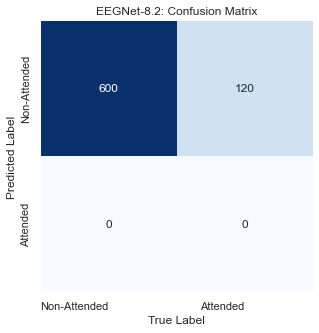

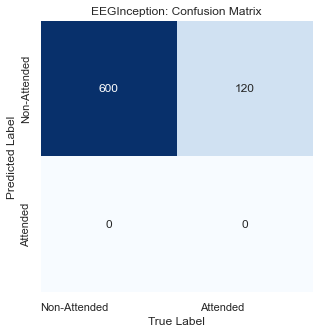

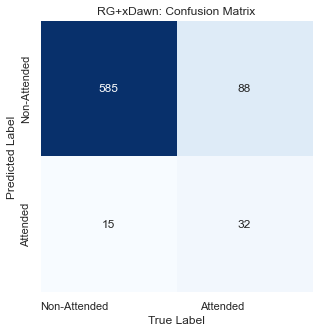

<Figure size 432x288 with 0 Axes>

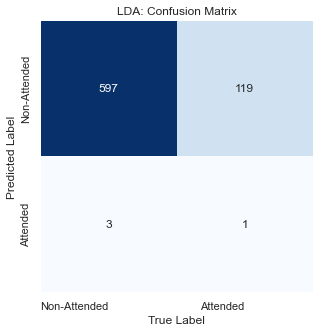

In [56]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Test the models and outout confusion matrix, precision and recall
def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.set(font_scale=1.0)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title + ": Confusion Matrix", fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
    ax.set_ylabel('Predicted Label', fontsize=12)
    ax.set_xlabel('True Label', fontsize=12)

def display_results(y_true, y_preds, class_labels,method):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print(method + " Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    print(results)
    return results
    
names        = ['Non-Attended', 'Attended']

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("EEGNet-8.2 Classification accuracy: %f " % (acc))

probs_i       = inception_model.predict(features_test)
preds_i       = probs_i.argmax(axis = -1)  
acc_i         = np.mean(preds_i == labels_test.argmax(axis=-1))
print("EEG Inception Classification accuracy: %f " % (acc_i))

preds_rg     = clf.predict(RG_test_data)
acc_r         = np.mean(preds_rg == RG_test_labels.argmax(axis = -1))
print("xDAWN + RG Classification accuracy: %f " % (acc_r))


preds_LDA = lda_model.predict(X_lda_test)
acc3         = np.mean(preds_LDA == Y_lda_test)
print("LDA Classification accuracy: %f " % (acc3))


 # Plot EEGNet Accuracy, Precision and recall

display_results(Y_test.argmax(axis = -1), preds, names , "EEGNet")
plt.figure(0)
fig, (ax3) = plt.subplots(1, 1, figsize=(6, 5))
plot_heatmap(preds, Y_test.argmax(axis = -1), names, ax3, title = 'EEGNet-8.2')


 # Plot EEGInception Accuracy, Precision and recall

display_results(labels_test.argmax(axis = -1), preds_i, names , "EEGInception")
plt.figure(0)
fig, (ax3) = plt.subplots(1, 1, figsize=(6, 5))
plot_heatmap(preds_i, labels_test.argmax(axis = -1), names, ax3, title = 'EEGInception')

# Plot RG+xDawn Accuracy, Precision and recall

display_results(RG_test_labels.argmax(axis = -1), preds_rg, names , "RG+xDawn")
plt.figure(0)
fig, (ax3) = plt.subplots(1, 1, figsize=(6, 5))
plot_heatmap(preds_rg,RG_test_labels.argmax(axis = -1), names, ax3, title = 'RG+xDawn')


 # Plot LDA Accuracy, Precision and recall
display_results(Y_lda_test, preds_LDA, names , "LDA")
plt.figure(0)
fig, (ax3) = plt.subplots(1, 1, figsize=(6, 5))
plot_heatmap(preds_LDA,Y_lda_test, names, ax3, title = 'LDA')

